<br><h1 align="Center"> <img src="https://serea2017.uniandes.edu.co/images/Logo.png" height="60" width="200" align="Center" />MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II</h1>
<h2 align="Center">
Presentado por:<br>
Fabián Cholo Acevedo - Cód 201523509<br>
Jaime Orjuela Viracacha - Cód 201924252<br>
</h2>

# Red neuronal recurrente: LSTM bidireccional

## Actividad 8

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

## Actividad en grupos
### Nombres:

**Instrucciones:** Por favor escriba los nombres de los integrantes de su grupo. Esta actividad debe ser entregada a más tardar dentro de 8 días, con la respuesta para los ejercicios y preguntas en cada numeral.

En este cuaderno vamos a implementar una red recurrente bi-direccional para la prediccion del sentimiento asociado con un comentario linguistico. Los comentarios con los que vamos a trabajar corresponden con opiniones sobre peliculas (https://ai.stanford.edu/~amaas/data/sentiment/)

Finalmente tenemos un ejercicio donde podremos explorar distintos modelos de redes recurrentes (https://en.wikipedia.org/wiki/Recurrent_neural_network)

Primero importemos las bibliotecas y paquetes que vamos a utilizar:

In [13]:
import numpy as np
import keras
from keras import layers
from keras.models import load_model, Sequential

import h5py
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

También definimos algunos parámetros para nuestra implementación, uno donde definimos el número máximo de términos a considerar (de todo nuestro vocabulario) y otro donde definimos la longitud máxima para un comentario:

In [14]:
max_features = 20000  # Considera las 20000 palabras más populares
maxlen = 200  # Considera las primeras 200 palabras de cada comentario

Importemos los datos:

In [15]:
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features)

print(len(x_train), "secuencias de entrenamiento")
print(len(x_val), "secuencias de validación")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

17465344/17464789 [==============================] - 9s 1us/step
25000 secuencias de entrenamiento
25000 secuencias de validación


**Salida esperada:**

25000 secuencias de entrenamiento

25000 secuencias de validación

Veamos en qué consiste la priemra observación de entrenamiento:

In [16]:
x_train[0]

array([    5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,    14,   407,    16,    82, 10311,     8,     4,
         107,   117,  5952,    15,   256,     4,     2,     7,  3766,
           5,   723,

Podemos reconstruir cada comentario de acuerdo con el índice de cada término:

In [17]:
L = keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

L = {k:(v+3) for k,v in L.items()}
L["<PAD>"] = 0
L["<START>"] = 1
L["<UNK>"] = 2
L["<UNUSED>"] = 3

L_palabra = {value:key for key,value in L.items()}

1646592/1641221 [==============================] - 1s 0us/step


Veamos el primer comentario de entrenamiento que es positivo:

In [18]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[0] ))
print("Tiene un sentimiento asociado: ", y_train[0])

El comentario:  and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was som

O un comentario negativo:

In [19]:
print("El comentario: ", ' '.join(L_palabra[id] for id in x_train[1] ))
print("Tiene un sentimiento asociado: ", y_train[1])

El comentario:  <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's an

## 1. Red recurrente bi-direccional

A continuación definimos la arquitectura de la red:

In [21]:
# Input con secuencias de enteros con longitud variable
inputs = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x = layers.Embedding(max_features, 128)(inputs)

# Añadimos 2 unidades LSTM bidireccionales
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

# Añadimos un clasificador binario en la salida
outputs = layers.Dense(1, activation="sigmoid")(x)

# Gaurdamos la arquitectura del modelo
model1 = keras.Model(inputs, outputs)
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])

# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3

# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# Inicializamos el error 
err_p = 999

for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
          
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    # Ajustamos el modelo
    history=model.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
      
    # Calculamos las metricas
    train_metrics = model.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model.evaluate(x=x_val, y=y_val, verbose=0)
    
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    
    if (loss_p < err_p):
        pathr =('BRNN_part='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])

print(x)


Epoch 1/3
391/391 [==============================] - 104s 265ms/step - loss: 0.4285 - accuracy: 0.7999 - val_loss: 0.3481 - val_accuracy: 0.8606
Epoch 2/3
391/391 [==============================] - 104s 267ms/step - loss: 0.2113 - accuracy: 0.9231 - val_loss: 0.4421 - val_accuracy: 0.7963
Epoch 3/3
391/391 [==============================] - 104s 265ms/step - loss: 0.1363 - accuracy: 0.9534 - val_loss: 0.4503 - val_accuracy: 0.8386
Desempeño (exactitud): accu_v1=0.8385599851608276 , accu_v2=0.8299999833106995
Epoch 1/3
391/391 [==============================] - 114s 291ms/step - loss: 0.2288 - accuracy: 0.9186 - val_loss: 0.2123 - val_accuracy: 0.9217
Epoch 2/3
391/391 [==============================] - 110s 281ms/step - loss: 0.1271 - accuracy: 0.9574 - val_loss: 0.2880 - val_accuracy: 0.8975
Epoch 3/3
391/391 [==============================] - 105s 269ms/step - loss: 0.0838 - accuracy: 0.9725 - val_loss: 0.3496 - val_accuracy: 0.9045
Desempeño (exactitud): accu_v1=0.90447998046875 , a

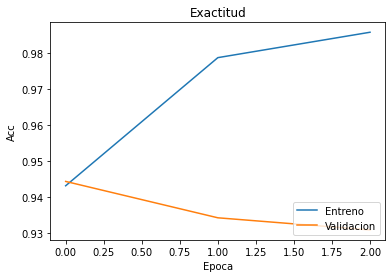

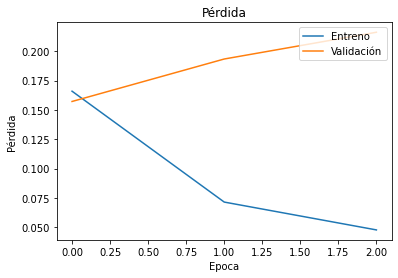

In [23]:
plt.figure(1)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

Recuperamos el mejor modelo:

In [24]:
# B-RNN LSTM
model_brnn = load_model('BRNN_part=3.h5')

model_brnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,757,761
Trainable params: 2,757,761
Non-trainable params: 0
_________________________________________________________________


Replicamos los resultados obtenidos anteriormente:

In [25]:
Y_predt = model_brnn.predict(x_train)
Y_predst = (Y_predt > 0.5)

print(confusion_matrix(y_train, Y_predst))
print("Exactitud: ", model_brnn.evaluate(x=x_train, y=y_train, verbose=0)[1])

[[10706  1794]
 [  579 11921]]
Exactitud:  0.9050800204277039


Reportamos el desempeño del modelo con los datos de prueba (fuera de la muestra):

In [26]:
Y_predv = model_brnn.predict(x_val)
Y_predsv = (Y_predv > 0.5)

print(confusion_matrix(y_val, Y_predsv))
print("Exactitud: ", model_brnn.evaluate(x=x_val, y=y_val, verbose=0)[1])

[[ 9469  3031]
 [ 1219 11281]]
Exactitud:  0.8299999833106995


## Ejercicio 1.1

Desarrolle un modelo de red neuronal recurrente uni-direccional para comparar los resultados obtenidos con esta red recurrente bi-direccional.

Puede explorar una red recurrente simple, LSTM ó GRU, o cualquier otro tipo de red que desee explorar que contenga al menos una capa de tipo recurrente (ver por ejemplo: https://keras.io/api/layers/#recurrent-layers).

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo.

# Redes Neuronales Recurrentes 

tomado de: <a href="https://www.diegocalvo.es/red-neuronal-recurrente/">Redes Neuronales Recurrente – RNN</a>

Una red neuronal recurrente no tiene una estructura de capas definida, sino que permiten conexiones arbitrarias entre las neuronas, incluso pudiendo crear ciclos, con esto se consigue crear la temporalidad, permitiendo que la red tenga memoria.
Las redes neuronales recurrentes son muy potentes para todo lo que tiene que ver con el análisis secuencias, como puede ser el análisis de textos, sonido o video.
<img src="https://www.diegocalvo.es/wp-content/uploads/2017/07/red-neuronal-recurrente.png" alt="Redes Neuronales Recurrentes RNN" width="500" height="600">


# Redes LSTM

Las redes LSTM (Long Short Term Memory) están compuestas por unidades LSTM y son un tipo especial de red neuronal recurrente descritas en 1997 por Hochreiter & Schmidhuber.
Las redes neuronales recurrentes convencionales presentan problemas en su entrenamiento debido a que los gradientes retropropagados tienden a crecer enormemente o a desvanecerse con el tiempo debido a que el gradiente depende no solo del error presente sino también los errores pasados. La acumulación de errores provoca dificultades para memorizar dependencias a largo plazo.
Estos problemas son solventados por las redes LSTM, para ello incorporan una serie de pasos para decidir que información va a ser almacenada y cual borrada.

<img src="https://www.diegocalvo.es/wp-content/uploads/2018/12/Red-LSTM.png" alt="Red LSTM">

La unidad de memoria LSTM contiene tres puertas que controlan el modo en que la información fluye dentro o fuera de la unidad.

<ul>
    <li><strong>Puerta de entrada</strong> ($x$) controla cuando la información nueva puede entrar en la memoria.</li>
    <li><strong>Puerta del olvido</strong> ($h$) controla cuando se olvida una parte de la información, lo que permite a la celda discriminar entre datos importantes y superfluos, dejando así sitio para nuevos datos.</li>
    <li><strong>Puerta de salida</strong> ($x_{t+1}$) controla cuando se utiliza en el resultado de los recuerdos almacenados en la celda.</li>
</ul>
La celda dispone de un mecanismo de optimización de las ponderaciones basado en el error de salida de la red resultante, que controla cada puerta. Este mecanismo se suele implementar con el algoritmo de capacitación, BPTT (<strong>B</strong>ack<strong>P</strong>ropagation <strong>T</strong>hrough <strong>T</strong>ime).
Finalmente destacar las redes LSTM se utilizan para compresión de textos de lenguajes naturales, reconocimiento de escritura a mano, reconocimiento de voz, reconocimiento de gestos, captura de imágenes.

# Redes GRU
Las redes GRU (Gated recurrent unit) están compuestas por unidades GRU y son un tipo especial de red neuronal recurrente descritas en 2014 por Kyunghyun Cho et al.

<img src="https://www.diegocalvo.es/wp-content/uploads/2018/12/Red-GRU.png" alt="Red GRU">

La unidad de memoria GRU contiene dos puertas que controlan el modo en que la información fluye dentro o fuera de la unidad: Puerta de actualización y una puerta de reajuste. 

<ul>
    <li><strong>La puerta de actualización</strong> indica cuánto del contenido de las celdas anteriores hay que mantener.</li>
    <li><strong>Puerta de reajuste</strong> define cómo incorporar la nueva entrada con los contenidos anteriores de la celda.</li>
</ul>

Nota: Se puede modelar una red neuronal recurrente estándar simplemente estableciendo la puerta de reajuste a 1 y la puerta de actualización a 0.


Las redes GRU son más simple que las LSTM, debido a que:

<ul>
    <li>Tienen menos parámetros.</li>
    <li>Carecen de puerta de salida.</li>
    <li>Capacitar más rápidamente.</li>
    <li>Más eficiente en su ejecución.</li>
</ul>


In [39]:
# Input con secuencias de enteros con longitud variable
inputs_lstm = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x_lstm = layers.Embedding(max_features, 128)(inputs_lstm)

# Añadimos 2 unidades LSTM Unidireccionales
x_lstm = layers.LSTM(64, return_sequences=True)(x_lstm)
x_lstm = layers.LSTM(64)(x_lstm)

# Añadimos un clasificador binario en la salida
outputs_lstm = layers.Dense(1, activation="sigmoid")(x_lstm)

# Arquitectura del modelo
model_lstm = keras.Model(inputs_lstm, outputs_lstm)
model_lstm.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_15 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
lstm_30 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_31 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 2,642,497
Trainable params: 2,642,497
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Inicializamos el error 
err_p = 999
for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_lstm = keras.Model(inputs_lstm, outputs_lstm)
    model_lstm.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    # Ajustamos el modelo
    history_lstm=model_lstm.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
    # Calculamos las metricas
    train_metrics = model_lstm.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_lstm.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_lstm.evaluate(x=x_val, y=y_val, verbose=0)
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    if (loss_p < err_p):
        pathr = ('LSTM_Unidireccional='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])
print(x)

Epoch 1/3
391/391 [==============================] - 90s 231ms/step - loss: 0.2302 - accuracy: 0.9128 - val_loss: 0.3388 - val_accuracy: 0.8599
Epoch 2/3
391/391 [==============================] - 89s 228ms/step - loss: 0.1284 - accuracy: 0.9542 - val_loss: 0.3689 - val_accuracy: 0.8497
Epoch 3/3
391/391 [==============================] - 97s 249ms/step - loss: 0.1091 - accuracy: 0.9620 - val_loss: 0.5180 - val_accuracy: 0.8516
Desempeño (exactitud): accu_v1=0.8515999913215637 , accu_v2=0.8386399745941162
Epoch 1/3
391/391 [==============================] - 123s 314ms/step - loss: 0.2428 - accuracy: 0.9091 - val_loss: 0.2183 - val_accuracy: 0.9209
Epoch 2/3
391/391 [==============================] - 111s 284ms/step - loss: 0.1220 - accuracy: 0.9593 - val_loss: 0.2628 - val_accuracy: 0.9022
Epoch 3/3
391/391 [==============================] - 113s 289ms/step - loss: 0.0698 - accuracy: 0.9784 - val_loss: 0.3547 - val_accuracy: 0.8992
Desempeño (exactitud): accu_v1=0.8992000222206116 , ac

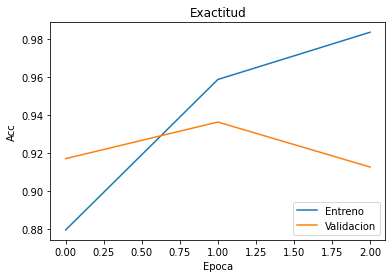

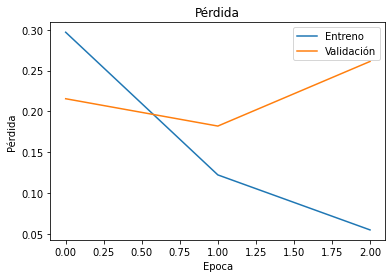

In [42]:
plt.figure(1)
plt.plot(history_lstm.history['accuracy'])  
plt.plot(history_lstm.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history_lstm.history['loss'])  
plt.plot(history_lstm.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

In [43]:
# Input con secuencias de enteros con longitud variable
inputs_gru = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x_gru = layers.Embedding(max_features, 128)(inputs_gru)

# Añadimos 2 unidades de GRU Unidireccionales
x_gru = layers.GRU(64, return_sequences=True)(x_gru)
x_gru = layers.GRU(64)(x_gru)

# Añadimos un clasificador binario en la salida
outputs_gru = layers.Dense(1, activation="sigmoid")(x_gru)

# Arquitectura del modelo
model_gru = keras.Model(inputs_gru, outputs_gru)
model_gru.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_16 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
gru (GRU)                    (None, None, 64)          37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 2,622,273
Trainable params: 2,622,273
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Inicializamos el error 
err_p = 999
for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_gru = keras.Model(inputs_gru, outputs_gru)
    model_gru.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    # Ajustamos el modelo
    history_gru=model_gru.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
    # Calculamos las metricas
    train_metrics = model_gru.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_gru.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_gru.evaluate(x=x_val, y=y_val, verbose=0)
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    if (loss_p < err_p):
        pathr = ('GRU_Unidireccional='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])
print(x)

Epoch 1/3
391/391 [==============================] - 85s 217ms/step - loss: 0.4877 - accuracy: 0.7532 - val_loss: 0.3572 - val_accuracy: 0.8496
Epoch 2/3
391/391 [==============================] - 88s 224ms/step - loss: 0.2403 - accuracy: 0.9062 - val_loss: 0.3881 - val_accuracy: 0.8489
Epoch 3/3
391/391 [==============================] - 88s 226ms/step - loss: 0.1336 - accuracy: 0.9533 - val_loss: 0.4624 - val_accuracy: 0.8254
Desempeño (exactitud): accu_v1=0.825439989566803 , accu_v2=0.8209999799728394
Epoch 1/3
391/391 [==============================] - 102s 260ms/step - loss: 0.2235 - accuracy: 0.9184 - val_loss: 0.2101 - val_accuracy: 0.9226
Epoch 2/3
391/391 [==============================] - 95s 243ms/step - loss: 0.0944 - accuracy: 0.9692 - val_loss: 0.2579 - val_accuracy: 0.9106
Epoch 3/3
391/391 [==============================] - 94s 239ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 0.3655 - val_accuracy: 0.9155
Desempeño (exactitud): accu_v1=0.9155200123786926 , accu_

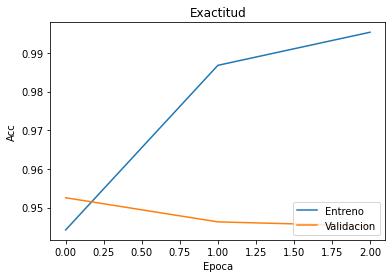

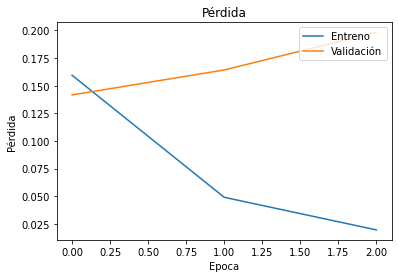

In [45]:
plt.figure(1)
plt.plot(history_gru.history['accuracy'])  
plt.plot(history_gru.history['val_accuracy'])  
plt.title('Exactitud')  
plt.ylabel('Acc')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validacion'], loc='lower right')
plt.show()

plt.figure(1) 
plt.plot(history_gru.history['loss'])  
plt.plot(history_gru.history['val_loss'])  
plt.title('Pérdida')  
plt.ylabel('Pérdida')  
plt.xlabel('Epoca')  
plt.legend(['Entreno', 'Validación'], loc='upper right')  
plt.show()

# Conclusión:


## Resultados LSTM inicial (bidireccional)
`
+--------+--------+--------+
| Exac_E | Exac_V | Exac_P |
+--------+--------+--------+
| 0.9716 | 0.8386 |  0.83  |
| 0.9894 | 0.9045 | 0.8446 |
| 0.9942 | 0.931  | 0.8408 |
+--------+--------+--------+
`

## Resultados LSTM (unidireccional)
`
+--------+--------+--------+
| Exac_E | Exac_V | Exac_P |
+--------+--------+--------+
| 0.9854 | 0.8516 | 0.8386 |
| 0.9874 | 0.8992 | 0.8336 |
| 0.984  | 0.9127 | 0.8186 |
+--------+--------+--------+
`

## Resultados GRU (unidireccional)
`
+--------+--------+--------+
| Exac_E | Exac_V | Exac_P |
+--------+--------+--------+
| 0.9765 | 0.8254 | 0.821  |
| 0.996  | 0.9155 | 0.8568 |
| 0.999  | 0.9453 | 0.857  |
+--------+--------+--------+
`

Comparando los modelos ejecutados y para el conjunto de datos analizado, con la red GRU con `random_state = 2` se obtienen mejores resultados.

## Ejercicio 1.2

Desarrolle otro modelo de red neuronal (de libre elección) para mejorar los resultados obtenidos con el mejor modelo obtenido hasta ahora.

Puede explorar una red recurrente simple, LSTM, GRU, o cualquier otro tipo de red (CNN, CNN-LSTM, ...)

Compare los resultados sobre los datos de prueba y analice el desempeño de su modelo. Concluya y proponga estrategias para seguir mejorando los resultados.

R/ Teniendo en cuenta los resultados obtenidos en el anterior punto, se implementará una red Bidirección de tipo GRU para comparar el desempeño de estos modelos.

In [47]:
# Input con secuencias de enteros con longitud variable
inputs_grub = keras.Input(shape=(None,), dtype="int32")

# Conseguimos la representación vectorial (embedding) de cada entero en un vector 128-dimensional
x_grub = layers.Embedding(max_features, 128)(inputs_grub)
# Añadimos 2 unidades de GRU Bidireccionales
x_grub = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x_grub)
x_grub = layers.Bidirectional(layers.GRU(64))(x_grub)
# Añadimos un clasificador binario en la salida
outputs_grub = layers.Dense(1, activation="sigmoid")(x_grub)
# Gaurdamos la arquitectura del modelo
model_grub = keras.Model(inputs_grub, outputs_grub)
model_grub.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 128)         74496     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 129       
Total params: 2,709,121
Trainable params: 2,709,121
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Inicializamos la tabla donde guardamos los resultados
x = PrettyTable(["Exac_E", "Exac_V", "Exac_P"])
# Definimos el número máximo de iteraciones (épocas de la red)
epocas=3
# Definimos los parametros del Adam
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# Inicializamos el error 
err_p = 999
for i in range(0,3,1):
    r = i^3
    CE_x, CV_x, CE_y, CV_y = train_test_split(x_train, y_train, test_size = 0.5, random_state = r)
    # Definimos el método de optimización con respecto a su funcion de perdida (además guardamos la exactitud para cada iteracion)
    model_grub = keras.Model(inputs_grub, outputs_grub)
    model_grub.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    # Ajustamos el modelo
    history_grub=model_grub.fit(x=CE_x, y=CE_y, epochs=epocas, validation_data=(CV_x, CV_y), verbose=1, shuffle=False)
    # Calculamos las metricas
    train_metrics = model_grub.evaluate(x=CE_x, y=CE_y, verbose=0)
    valid_metrics = model_grub.evaluate(x=CV_x, y=CV_y, verbose=0)
    test_metrics = model_grub.evaluate(x=x_val, y=y_val, verbose=0)
    # Guardamos las métricas de desempeño
    accu_e = train_metrics[1]
    loss_e = train_metrics[0]
    accu_v = valid_metrics[1]
    loss_v = valid_metrics[0]
    accu_p = test_metrics[1]
    loss_p = test_metrics[0]
    if (loss_p < err_p):
        pathr = ('GRU_Bidireccional='+str(r)+'.h5')
        model.save(pathr) 
        err_p = loss_p
    # Imprimimos el desempeño para cada repetición
    print('Desempeño (exactitud): accu_v1='+str(accu_v) +' , accu_v2='+str(accu_p))
    x.add_row([np.round(accu_e,4), np.round(accu_v,4), np.round(accu_p,4)])
print(x)

Epoch 1/3
391/391 [==============================] - 144s 368ms/step - loss: 0.4702 - accuracy: 0.7607 - val_loss: 0.3450 - val_accuracy: 0.8562
Epoch 2/3
391/391 [==============================] - 140s 359ms/step - loss: 0.2329 - accuracy: 0.9094 - val_loss: 0.3542 - val_accuracy: 0.8659
Epoch 3/3
391/391 [==============================] - 129s 331ms/step - loss: 0.1279 - accuracy: 0.9568 - val_loss: 0.5132 - val_accuracy: 0.8266
Desempeño (exactitud): accu_v1=0.8265600204467773 , accu_v2=0.8185200095176697
Epoch 1/3
391/391 [==============================] - 114s 290ms/step - loss: 0.2092 - accuracy: 0.9214 - val_loss: 0.1964 - val_accuracy: 0.9283
Epoch 2/3
391/391 [==============================] - 113s 289ms/step - loss: 0.0652 - accuracy: 0.9800 - val_loss: 0.3363 - val_accuracy: 0.9155
Epoch 3/3
391/391 [==============================] - 109s 278ms/step - loss: 0.0299 - accuracy: 0.9910 - val_loss: 0.3504 - val_accuracy: 0.9129
Desempeño (exactitud): accu_v1=0.912880003452301 , 


## Resultados GRU (unidireccional)
`
+--------+--------+--------+
| Exac_E | Exac_V | Exac_P |
+--------+--------+--------+
| 0.9765 | 0.8254 | 0.821  |
| 0.996  | 0.9155 | 0.8568 |
| 0.999  | 0.9453 | 0.857  |
+--------+--------+--------+
`

## Resultados GRU (bidireccional)
`
+--------+--------+--------+
| Exac_E | Exac_V | Exac_P |
+--------+--------+--------+
|  0.97  | 0.8266 | 0.8185 |
| 0.9945 | 0.9129 | 0.8562 |
| 0.9982 | 0.9409 | 0.8565 |
+--------+--------+--------+
`

De acuerdo a los modelos evaluados, se concluye que las redes GRU presentan un mejor rendimiento para el conjunto de datos analizado. Sin embargo, aunque no se detectan diferencias significativas en desempeño entre el modelo GRU unidireccional y el bidireccional, el tiempo de ejecución de la red bidireccional SI es significativamente mayor, por lo que se concluye que para el conjunto de datos analizado, la red GRU unidireccional es la mejor alternativa.